In [1]:
import numpy as np
import cv2, scipy
from matplotlib import pyplot as plt
from glob import glob
from src.tool import * 
from src.piece_process import *
from src.tile import *

img_paths = glob("input/*.jpg")

In [3]:
%%time
pieces = []
piece_masks = []
for img_path in img_paths:
    img = cv2.imread(img_path)
    img_warped = get_warp_image(img, margin=20)
    img_balanced = white_balance(img_warped)
    mask = find_outline_rough(img_balanced)
    
    img_overlap = kmeans_color_purifier(mask, img_balanced, n_clusters=10, t=0.9, iterations=3)
    img_overlap = kmeans_color_purifier(img_overlap, img_balanced, n_clusters=10, t=0.8, iterations=3)
    pieces_mask, output = pieces_searching(img_overlap) 
    
    for piece in pieces_mask:
        image_area = piece.shape[0] * piece.shape[1]  
        piece_mask_cropped, piece_cropped = crop_piece(piece, img_warped)
        piece_mask_refined = refine_piece(piece_mask_cropped, image_area)
        pieces.append(piece_cropped)
        piece_masks.append(piece_mask_refined)

C:\Users\tangji\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


Wall time: 2min 44s


In [6]:
%%time
corners = []
for piece_mask in piece_masks:
    corners.append(get_tile_corners(piece_mask))   

d:\workspace\Python\jigsaw-puzzle-solver\src\piece_process.py:218: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
d:\workspace\Python\jigsaw-puzzle-solver\src\piece_process.py:286: RuntimeWarning: invalid value encountered in greater
  (np.array_equal(c2, t4) and np.array_equal(c4, t2)))) and 90 - angle_margin < get_angle(c2,c3,c4) < 90 + angle_margin and 90 - angle_margin < get_angle(c3, c4, c1) < 90 + angle_margin:
d:\workspace\Python\jigsaw-puzzle-solver\src\piece_process.py:251: RuntimeWarning: invalid value encountered in less
  if get_angle(c2, tile_center, c1) < angle_diff:


Wall time: 3min 5s


In [7]:
%%time
tiles = []
for i in range(len(piece_masks)):
    tiles.append(Tile(pieces[i], piece_masks[i], corners[i]))

Wall time: 1min 28s


In [8]:
b = np.ones((600*10,600*10,3), dtype=np.uint8)*255
for i, t in enumerate(tiles):
#     t.scale(0.5)
    overlay_image_alpha(b, t.img, np.array([i%10 * 600,i//10 * 600])+100-t.corners[0][0], t.mask)

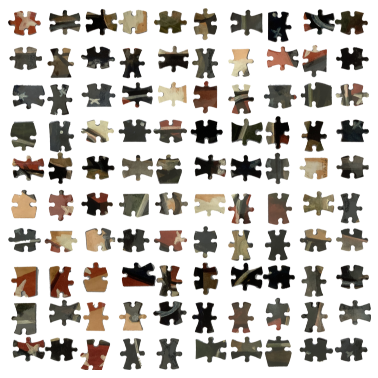

In [9]:
show([b])

In [8]:
import pickle
pickle.dump(tiles, open("tiles.pk", "wb"))

In [3]:
import pickle
tiles = pickle.load(open("tiles.pk", "rb"))

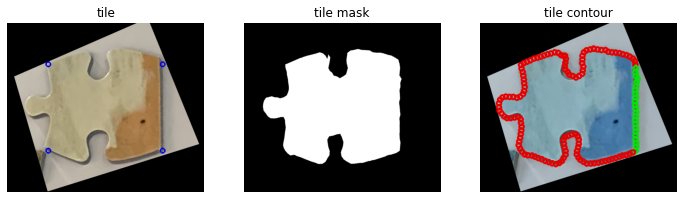

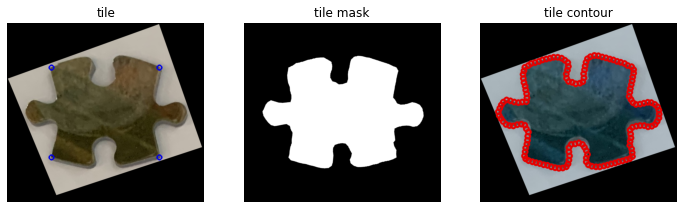

In [10]:
for i in range(3, 5):
    tiles[i].show()

In [11]:
b = np.ones((600*10,600*10,3), dtype=np.uint8)*255
for i, t in enumerate(tiles):
    overlay_image_alpha(b, t.img, np.array([i%10 * 600,i//10 * 600])+100-t.corners[0][0], t.mask)
    for j in range(4):
        color = (0,230,0)
        if t.v[j]>t.threshold:
            color = (230,0,0)
        for c in t.contour[t.labels==j]:
            b = cv2.circle(b, tuple(np.array([i%10 * 600,i//10 * 600])+100-t.corners[0][0]+np.array(c)), 8, color, thickness=5)

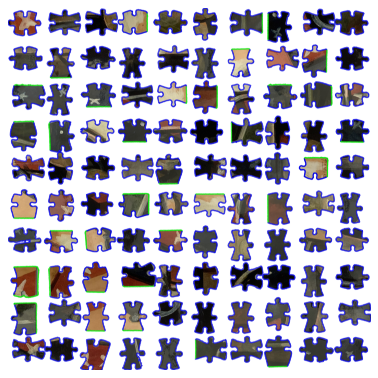

In [12]:
show([b])

In [13]:
def get_label_direction(label, t):
    axis = np.argmax(np.abs(t.center-np.mean(t.contour[t.labels==label], axis=0)))
    s = t.center[axis]-np.mean(t.contour[t.labels==label], axis=0)[axis]
    if s > 0:
        if axis == 0:
            # left
            return 0
        else:
            # down
            return 1
    else:
        if axis == 0:
            # right
            return 2
        else:
            # up
            return 3

def get_edge_directions(t):
    labels_edge = (np.array(t.v) <= t.threshold)
    ret = []
    for i, l in enumerate(labels_edge):
        if l:
            ret.append(get_label_direction(i, t))
    return ret

def rotate_until(t, cond):
    while True:
        d = cond.copy()
        for c in get_edge_directions(t):
            if c in d:
                d.remove(c)
        if len(d) == 0:
            return
        t.rotate()
        
def overlay_image_area(img, img_overlay, pos, alpha_mask, img_new):
    x, y = pos

    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])
    img = img.copy()
    area = img[y1:y2, x1:x2, :]

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return
    channels = img.shape[2]

    alpha = np.array(alpha_mask==255)[y1o:y2o, x1o:x2o]
    alpha_inv = np.invert(np.array(alpha))
    r = (np.sum(area, axis=-1) != 0) * alpha
    for c in range(channels):
        img1 = img_overlay[y1o:y2o, x1o:x2o, c]
        img2 = area[:, :, c]
        area[:, :, c] = (alpha * img1 + alpha_inv * img2)
    # overlap surface + cave surface
    return np.sum(r) + (np.sum(img_new != 0) - np.sum((img_new != 0) * (np.sum(img, axis=-1) != 0)))

def overlap_area(t1, Ts, action=None):
    img1 = np.zeros((t1.img.shape[1], t1.img.shape[0], 3), dtype=np.uint8)
    img1 = overlay_image_alpha(img1, t1.img, (0,0), t1.mask)
    ret = []
    for t2 in Ts:
        if action is not None:
            action(t2)
        c1 = t1.center
        c2 = t1.corners[1]-t2.corners[0]+t2.center
        p = get_closer_point(t1.corners[2], t1.corners[1]-t2.corners[0]+t2.corners[3], c1, c2)
        img2 = np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8)
        img2 = cv2.fillConvexPoly(img2, np.array([clockwise_corners([t1.corners[1], p, c1, c2])], dtype=np.int32), (255))
        r = overlay_image_area(img1, t2.img, t1.corners[1]-t2.corners[0], t2.mask, img2)
        ret.append(r)
    return ret

def connect(t1, t2):
    y = max(t1.corners[1][1]-t2.corners[0][1]+t2.img.shape[1], t1.img.shape[1])
    x = max(t1.corners[1][0]-t2.corners[0][0]+t2.img.shape[0], t1.img.shape[0])
    img1 = np.zeros((y, x, 3), dtype=np.uint8)
    img1 = overlay_image_alpha(img1, t1.img, (0,0), t1.mask)
    img1 = overlay_image_alpha(img1, t2.img, t1.corners[1]-t2.corners[0], t2.mask)
    return img1

def get_closer_point(p1, p2, c1, c2):
    if dis_point_line(c1, c2, p1) < dis_point_line(c1, c2, p2):
        return p1
    return p2

In [14]:
tiles_2 = [t for t in tiles if t.n_edges == 2]
tiles_1 = [t for t in tiles if t.n_edges == 1]
tiles_0 = [t for t in tiles if t.n_edges == 0]
print(len(tiles_2), len(tiles_1), len(tiles_0))

3 31 65


In [19]:
t = tiles_2[3]
# put edges face bottom left corner
rotate_until(t, [0, 1])

def action(t2):
    rotate_until(t2, [1])
ret = overlap_area(t, tiles_1, action)
np.argsort(ret)

array([ 5,  7,  8,  4, 15, 27, 10,  9, 16,  3, 14, 23, 21, 28, 30,  1, 17,
       24, 19, 11, 12, 31,  2, 26, 13, 25, 29,  6, 18, 20, 22,  0],
      dtype=int64)

In [ ]:
# TO DO remove image balancing

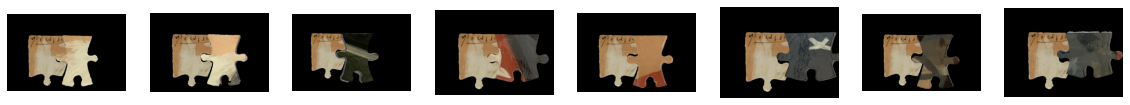

In [14]:
t1 = t
imgs = []
for i in range(8):
    t2 = tiles_1[np.argsort(ret)[i]]
    imgs.append(connect(t1, t2))
show(imgs, h=20)

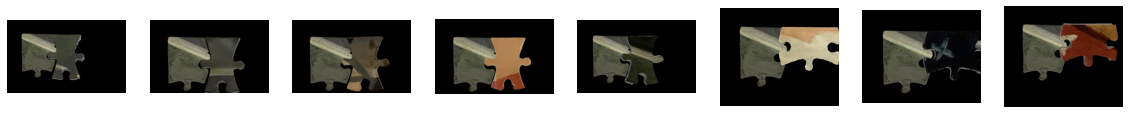

In [16]:
t1 = t
imgs = []
for i in range(8):
    t2 = tiles_1[np.argsort(ret)[i]]
    imgs.append(connect(t1, t2))
show(imgs, h=20)

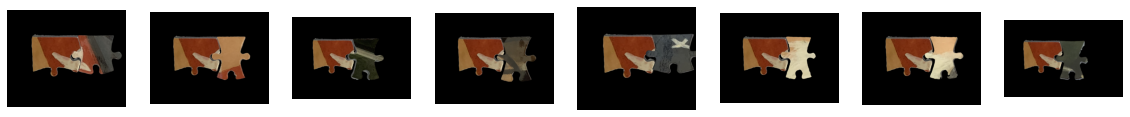

In [18]:
t1 = t
imgs = []
for i in range(8):
    t2 = tiles_1[np.argsort(ret)[i]]
    imgs.append(connect(t1, t2))
show(imgs, h=20)

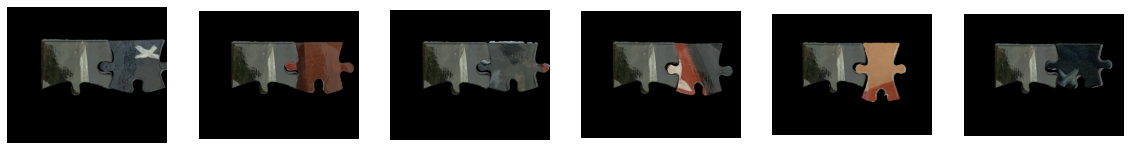

In [326]:
t1 = t
imgs = []
for i in range(6):
    t2 = tiles_1[np.argsort(ret)[i]]
    imgs.append(connect(t1, t2))
show(imgs, h=20)

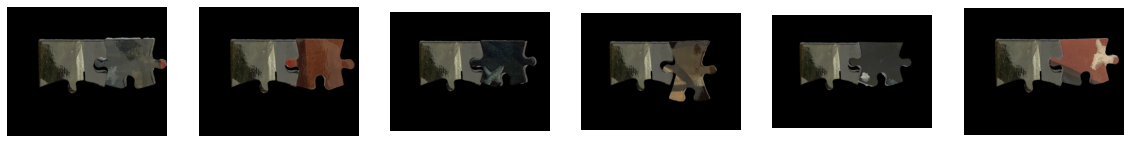

In [20]:
t1 = t
imgs = []
for i in range(6,12):
    t2 = tiles_1[np.argsort(ret)[i]]
    imgs.append(connect(t1, t2))
show(imgs, h=20)

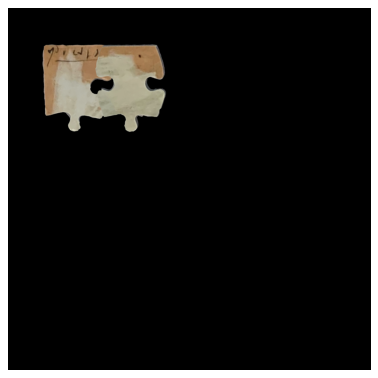

In [46]:
img = np.zeros((2000, 2000, 3), dtype=np.uint8)
img = overlay_image_alpha(img, t.img, (0, 0), t.mask)
img = overlay_image_alpha(img, t2.img, t.corners[1]-t2.corners[0], t2.mask)
show([img])

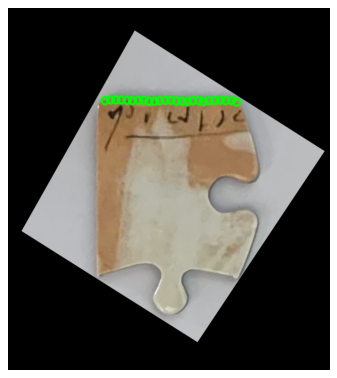

In [360]:
annotate_points(t.img, t.contour[t.labels==1])